In [1]:
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import evaltools as et, viz_tools
import cmocean as cmo
import datetime as dt
import netCDF4 as nc
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import cmocean
import f90nml
import os
import pickle

%matplotlib inline

In [2]:
# path to model files:
PATH= '/results2/SalishSea/nowcast-green.201905/'

# start and end dates for analysis:
start_date = dt.datetime(2013,1,1)
end_date = dt.datetime(2017,1,1)

# number of days per model file:
flen=1

# dictionary mapping desired model variables to the file types where they are found
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T',
         'flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}

# dictionary mapping model file types to their time resolution in hours (1 is hourly files, 24 is daily)
fdict={'ptrc_T':1,'grid_T':1}

# results format
# -- nowcast: files like 01jan15/SalishSea_1h_20150101_20150101_ptrc_T.nc
# -- long: files like SalishSea_1h_20150206_20150804_ptrc_T_20150427-20150506.nc, all in one directory
namfmt='nowcast'

# path to directory containing database: 
# obsDir='/ocean/shared/SalishSeaCastData/DFO/BOT/' #normal obs dir
obsDir='/data/eolson/MEOPAR/OBS/'            #temporary obs dir
#(dbname defaults to 'DFO_OcProfDB.sqlite')

# Where to store last pickle file:
pkldir='/data/eolson/results/MEOPAR/clusterGroups/'

### 1) load DFO data and match it to model output: don't repeat this part unless you want to look at different years (outside 2013-2016)

In [3]:
# load DFO bottle data (returns pandas dataframe)
# AbsSal is Absolute (actually reference) Salinity, and ConsT is Conservative Temperature
# N is nitrate+nitrate, Si is Silicate; Chlorophyll_Extracted; Z is depth (m); dtUTC is datetime in UTC
# excludeSaanich=True -> do not include data from Saanich Inlet
df1=et.loadDFO(basedir=obsDir,datelims=(start_date,end_date),excludeSaanich=True,)
print(len(df1))
df1.head()

5409


,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,2013.0,4.0,11.0,20.848333,49.402167,-124.1555,2.6,None,None,None,11.82,mg/m^3,3.0,7.2,umol/L,27.743770,9.789540,2.57784,2013-04-11 20:50:54
1,2013.0,4.0,11.0,20.848333,49.402167,-124.1555,4.8,None,None,None,11.67,mg/m^3,2.9,7.3,umol/L,27.744457,9.787385,4.75906,2013-04-11 20:50:54
2,2013.0,4.0,11.0,20.848333,49.402167,-124.1555,10.2,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,27.749606,9.667316,10.1129,2013-04-11 20:50:54
3,2013.0,4.0,11.0,20.848333,49.402167,-124.1555,19.7,None,None,None,11.88,mg/m^3,10.6,18.5,umol/L,28.459715,9.127710,19.5313,2013-04-11 20:50:54
4,2013.0,4.0,11.0,20.848333,49.402167,-124.1555,29.9,None,None,None,NaN,mg/m^3,24.1,47.6,umol/L,29.363611,8.447678,29.6432,2013-04-11 20:50:54


In [4]:
# match model output to observations and return both in a dataframe
# the model variables will have their original names prefixed by mod_, eg mod_vosaline
# the observation file names are unchanged. 
data=et.matchData(data=df1,filemap=filemap, fdict=fdict, mod_start=start_date, mod_end=end_date, 
                  mod_nam_fmt=namfmt, mod_basedir=PATH, mod_flen=flen,
                  meshPath='/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')

(Lat,Lon)= 49.29966666666667 -123.09016666666666  not matched to domain
(Lat,Lon)= 49.97083333333333 -124.68266666666666  not matched to domain
(Lat,Lon)= 49.97083333333333 -124.6825  not matched to domain
(Lat,Lon)= 49.97266666666667 -124.686  not matched to domain
(Lat,Lon)= 49.972833333333334 -124.686  not matched to domain
(Lat,Lon)= 49.979 -124.68883333333333  not matched to domain
(Lat,Lon)= 49.979 -124.68833333333333  not matched to domain
(Lat,Lon)= 49.982 -124.6925  not matched to domain
(Lat,Lon)= 49.983333333333334 -124.69383333333333  not matched to domain
(Lat,Lon)= 49.98866666666667 -124.6995  not matched to domain
(Lat,Lon)= 49.98866666666667 -124.69916666666667  not matched to domain
(Lat,Lon)= 49.99483333333333 -124.709  not matched to domain
(Lat,Lon)= 49.995333333333335 -124.70866666666667  not matched to domain
(Lat,Lon)= 50.004666666666665 -124.71333333333334  not matched to domain
(Lat,Lon)= 50.00516666666667 -124.7145  not matched to domain
(Lat,Lon)= 50.01766666

In [11]:
pickle.dump(data,open(os.path.join(obsDir,'DFOmatch2013_2016.pkl'),'wb'))

In [3]:
data=pickle.load(open(os.path.join(obsDir,'DFOmatch2013_2016.pkl'),'rb'))

In [4]:
#Chl:N ratio used later in plots; get value from namelist associated with model output
mod_chl_N=et.getChlNRatio(basedir=PATH,nam_fmt='nowcast')
print(mod_chl_N)

1.8


/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


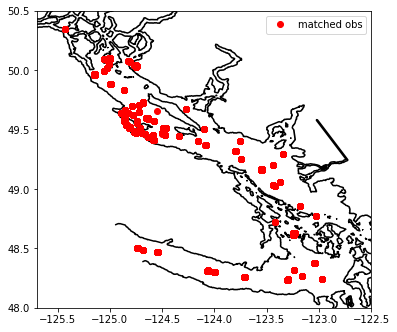

In [5]:
# plot matched data locations
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='matched obs')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

In [6]:
# add column for day of year
data['YD']=et.datetimeToYD(data['dtUTC'])

In [7]:
data.dropna(axis=1,how='all',inplace=True)

In [8]:
def logt(x):
    return np.log10(x+.001)

In [9]:
# chlorophyll calculations
data['l10_obsChl']=logt(data['Chlorophyll_Extracted'])
data['l10_modChl']=logt(mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates']))
data['mod_Chl']=mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])
data['Chl']=data['Chlorophyll_Extracted']

### 2) add Cluster info: Also don't need to repeat this unless you want other years

In [10]:
start_date = dt.datetime(2013,1,1)
end_date = dt.datetime(2017,1,1)
clusterD='/data/tjarniko/MEOPAR/analysis_tereza/notebooks/CLUSTER_PAPER/CLEAN/KEY_PAPERFIGURES/pkls/'
cxf='Xcoords_for571_stations.pkl'
cyf='Ycoords_for571_stations.pkl'
cfile={2013:'BIO_clno_5_2013_reass.pkl',
       2014:'BIO_clno_5_2014_reass.pkl',
       2015:'BIO_clno_5_2015_reass.pkl',
       2016:'BIO_clno_5_2016_reass.pkl'} # only 2015 and 2016 overlap with hplc
cver='BIO'

In [11]:
cx=pickle.load(open(clusterD+cxf, 'rb'))
cy=pickle.load(open(clusterD+cyf, 'rb'))
cf=dict()
for iyear in cfile.keys():
    cf[iyear]=pickle.load(open(clusterD+cfile[iyear],'rb'))

In [12]:
def round2(num):
    return int(np.trunc((num+2)/10)*10+2)

In [13]:

data['Year']=[ii.year for ii in data['dtUTC']]

In [14]:
data['Cluster']=np.zeros(len(data))

In [15]:
for ir, row in data.iterrows():
    ii=(cx==round2(row['i']))&(cy==round2(row['j']))
    if sum(ii)==1:
        cluster=cf[row['Year']][ii]
        data.at[ir,'Cluster']=int(cluster)

In [16]:
# number of points not assigned a cluster, total length of dataframe:
np.sum(data['Cluster']==0),len(data)

(802, 5172)

In [20]:
pickle.dump(data,open(os.path.join(pkldir,'DFODataModelClusterBIO.pkl'),'wb'))

# Jump to here to load pandas dataframe containing DFO Obs, model values, and Cluster ID

In [3]:
data=pickle.load(open(os.path.join(pkldir,'DFODataModelClusterBIO.pkl'),'rb'))

In [4]:
# create dictionary of dataframe views by year
datyr=dict()
yy=np.array([ii.year for ii in data['dtUTC']])
yys=np.unique(yy)
for yr in yys:
    datyr[yr]=data.loc[yy==yr]

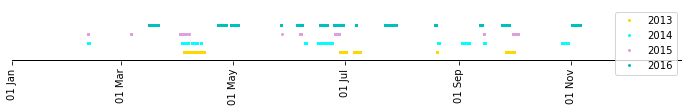

In [5]:
# plot matched data sampling times
clist=('gold','aqua','plum','c','m','r','g','b','brown','gray')
fig,axL=plt.subplots(1,1,figsize=(12,1))
for ii, yr in enumerate(yys):
    dshift=dt.datetime(yys[0],1,1)-dt.datetime(yr,1,1)
    axL.plot(datyr[yr].dtUTC+dshift,np.zeros(np.shape(datyr[yr].dtUTC))+.1*ii,'.',
             color=clist[ii],markersize=4,label=str(yr))
axL.set_yticks(());
yearsFmt = mdates.DateFormatter('%d %b')
axL.xaxis.set_major_formatter(yearsFmt)
axL.xaxis.set_ticks([dt.datetime(int(yys[0]),1,1), dt.datetime(int(yys[0]),3,1),dt.datetime(int(yys[0]),5,1),dt.datetime(int(yys[0]),7,1),
                     dt.datetime(int(yys[0]),9,1),dt.datetime(int(yys[0]),11,1),dt.datetime(int(yys[0])+1,1,1)])
for tick in axL.get_xticklabels():
        tick.set_rotation(90)
        tick.set_horizontalalignment('center')
axL.set_ylim(-.1,.1*(len(datyr.keys())+1))
axL.set_xlim(dt.datetime(yys[0],1,1),dt.datetime(yys[0],12,31))
axL.legend()
axL.set_frame_on(False)
xmin, xmax = axL.get_xaxis().get_view_interval()
ymin, ymax = axL.get_yaxis().get_view_interval()
axL.add_artist(mpl.lines.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

#### Display stats

In [6]:
print('Chl depth<15:') 
et.printstats(data.loc[data.Z<15,:],'Chl','mod_Chl')
for icl in range(1,6):
    print('cluster',icl)
    et.printstats(data.loc[data.Cluster==icl,:],'Chl','mod_Chl')

Chl depth<15:
  N: 642
  bias: -1.3395055021806757
  RMSE: 4.549682016746764
  WSS: 0.5350645218542115
cluster 1
  N: 43
  bias: -1.1552964614608952
  RMSE: 2.387960984476491
  WSS: 0.6708493743865336
cluster 2
  N: 9
  bias: -1.12594534718328
  RMSE: 1.8841352347378093
  WSS: 0.8178382953743568
cluster 3
  N: 475
  bias: -1.306962329307321
  RMSE: 4.2438651079241465
  WSS: 0.5872143271385234
cluster 4
  N: 133
  bias: -0.9740403640261832
  RMSE: 3.9609871167036426
  WSS: 0.41044804034465276
cluster 5
  N: 222
  bias: -1.2525440324229193
  RMSE: 4.051850156632231
  WSS: 0.4922855952018429


### mod vs. obs plots

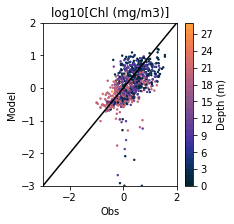

In [8]:
cm1=cmocean.cm.thermal
bounds = np.array(np.arange(0,30))
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=200)
#pcm = ax[1].pcolormesh(X, Y, Z1, norm=norm, cmap='RdBu_r')
fig,ax=plt.subplots(1,1,figsize=(3,3))
args={'marker':'.','s':8,'norm':norm}
ps=et.varvarScatter(ax,data,'l10_obsChl','l10_modChl','Z',cm=cm1,args=args)
cb=fig.colorbar(ps,ax=ax,boundaries=np.arange(0,30))
cb.set_label('Depth (m)')
ax.set_ylabel('Model')
ax.set_xlabel('Obs')
ax.set_title('log10[Chl (mg/m3)]')
ax.set_xlim(-3,2)
ax.set_ylim(-3,2)
ax.plot((-3,2),(-3,2),'k-')


/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/viz_tools.py:123: UserWarning: No contour levels were found within the data range.
  contour_lines = axes.contour(


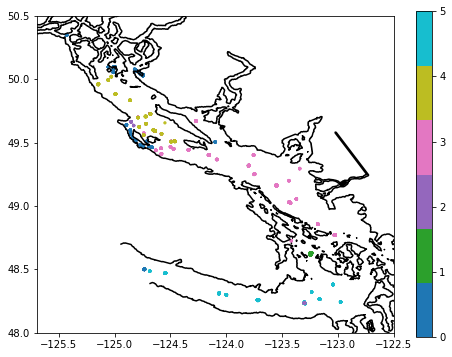

In [9]:
### map clusters
fig, ax = plt.subplots(figsize = (8,6))
viz_tools.set_aspect(ax, coords = 'map')
m=ax.scatter(data['Lon'], data['Lat'],c=data['Cluster'],s=5,cmap=plt.get_cmap('tab10',6))
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
plt.colorbar(m)
ax.set_ylim(48, 50.5)
ax.set_xlim(-125.7, -122.5);

In [10]:
## Plot residuals by year day for each cluster

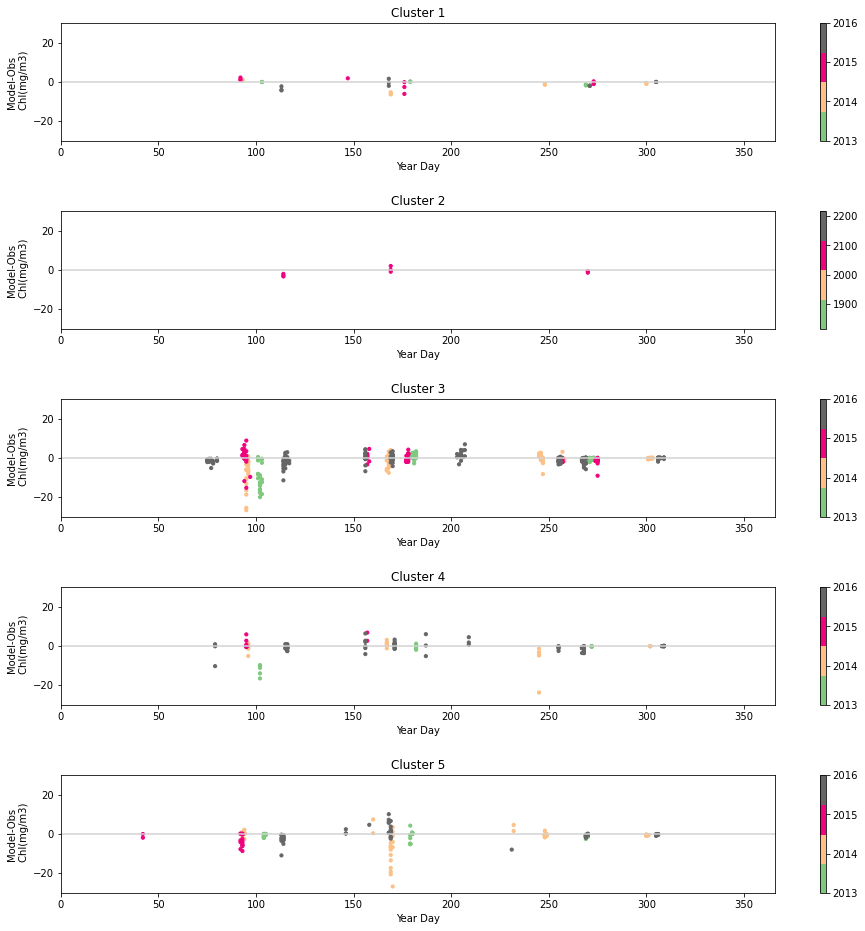

In [11]:
fig,ax=plt.subplots(5,1,figsize=(16,16))
fig.subplots_adjust(hspace=.6)
for icl in range(1,6):
    icld=data.loc[data.Cluster==icl]
    ix=ax[icl-1]
    m=ix.scatter(icld['YD'],icld['mod_Chl']-icld['Chl'],c=icld['Year'],s=10,cmap=plt.get_cmap('Accent',4))
    ix.set_xlabel('Year Day')
    ix.set_ylabel('Model-Obs\n Chl(mg/m3)')
    ix.set_xlim(0,366)
    ix.set_ylim(-30,30)
    ix.set_title(f'Cluster {icl}')
    fig.colorbar(m,ax=ix)
    ix.plot((0,366),(0,0),'-',color='lightgray')

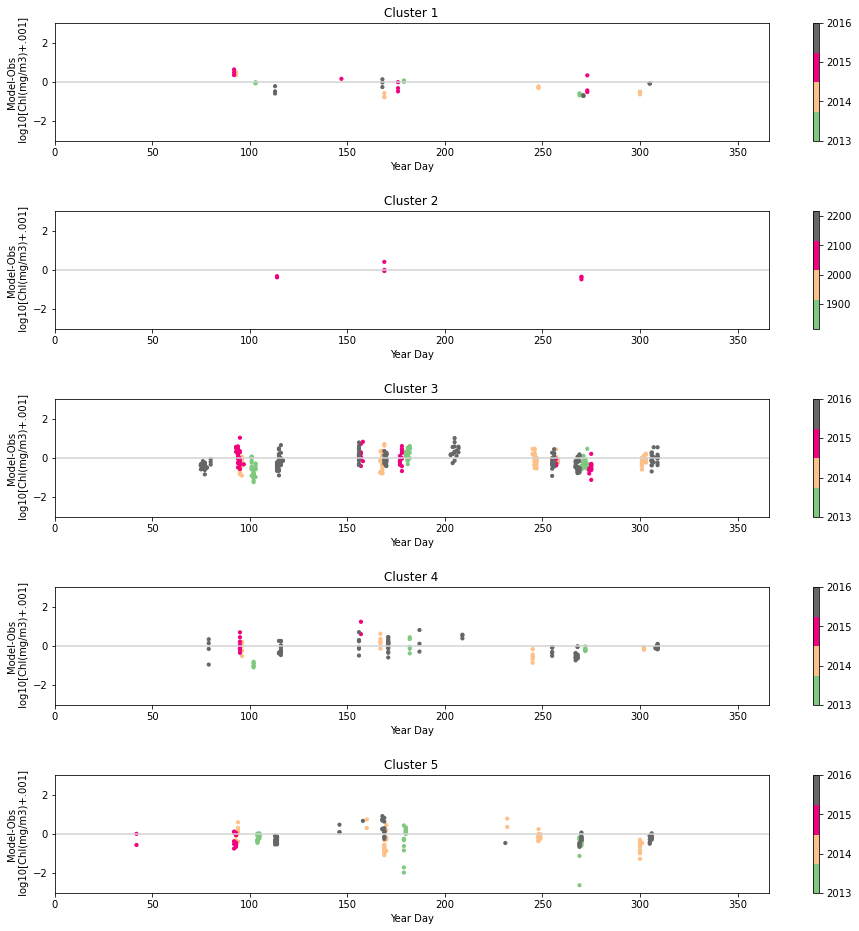

In [12]:
fig,ax=plt.subplots(5,1,figsize=(16,16))
fig.subplots_adjust(hspace=.6)
for icl in range(1,6):
    icld=data.loc[data.Cluster==icl]
    ix=ax[icl-1]
    m=ix.scatter(icld['YD'],icld['l10_modChl']-icld['l10_obsChl'],c=icld['Year'],s=10,cmap=plt.get_cmap('Accent',4))
    ix.set_xlabel('Year Day')
    ix.set_ylabel('Model-Obs\n log10[Chl(mg/m3)+.001]')
    ix.set_xlim(0,366)
    ix.set_ylim(-3,3)
    ix.set_title(f'Cluster {icl}')
    fig.colorbar(m,ax=ix)
    ix.plot((0,366),(0,0),'-',color='lightgray')